In [41]:
# Import Part One Libraries
import numpy as np
import pandas as pd
import matplotlib as mp
import statsmodels.api as sm
from statsmodels.sandbox.regression.gmm import IV2SLS
from statsmodels.sandbox.regression.gmm import GMM

# Import Part Two Libraries
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Part 1

In [42]:
# Import partone.csv and confirm valid dataset
input_table = pd.read_csv('https://raw.githubusercontent.com/EthanRosehart/PM_Assignments/refs/heads/main/midterm_partone.csv')
input_table.head()

,Constant,Stock Change,Inventory Turnover,Operating Profit,Interaction Effect,Current Ratio,Quick Ratio,Debt Asset Ratio
0,1,0.870332,1.795946,0.115846,0.208053,1.672527,0.255171,0.473317
1,1,-0.047347,1.395501,0.436967,0.609788,1.637261,0.221763,0.489967
2,1,0.001176,1.664563,0.541016,0.900555,1.640619,0.189141,0.374269
3,1,-0.901200,1.605738,0.539399,0.866133,1.436221,0.131944,0.224399
4,1,-0.176353,1.591451,0.539938,0.859285,1.433140,0.183095,0.213446


In [43]:
# Define and run the original GMM model done in class

y_vals  = np.array(input_table["Stock Change"])
x_vals  = np.array(input_table[["Inventory Turnover","Operating Profit","Interaction Effect"]])
iv_vals = np.array(input_table[["Current Ratio","Quick Ratio","Debt Asset Ratio"]])

class gmm(GMM):
    def momcond(self, params):
        p0, p1, p2, p3 = params
        endog = self.endog
        exog = self.exog
        inst = self.instrument   

        error0 = endog - p0 - p1 * exog[:,0] - p2 * exog[:,1] - p3 * exog[:,2]
        error1 = (endog - p0 - p1 * exog[:,0] - p2 * exog[:,1] - p3 * exog[:,2]) * exog[:,1]
        error2 = (endog - p0 - p1 * exog[:,0] - p2 * exog[:,1] - p3 * exog[:,2]) * exog[:,2]
        error3 = (endog - p0 - p1 * exog[:,0] - p2 * exog[:,1] - p3 * exog[:,2]) * inst[:,0] 
        error4 = (endog - p0 - p1 * exog[:,0] - p2 * exog[:,1] - p3 * exog[:,2]) * inst[:,1] 
        error5 = (endog - p0 - p1 * exog[:,0] - p2 * exog[:,1] - p3 * exog[:,2]) * inst[:,2] 

        g = np.column_stack((error0, error1, error2, error3, error4, error5))
        return g


beta0 = np.array([0.1, 0.1, 0.1, 0.1])
res = gmm(endog = y_vals, exog = x_vals, instrument = iv_vals, k_moms=6, k_params=4).fit(beta0)

res.summary()

Optimization terminated successfully.
         Current function value: 0.000046
         Iterations: 8
         Function evaluations: 12
         Gradient evaluations: 12
Optimization terminated successfully.
         Current function value: 0.000373
         Iterations: 7
         Function evaluations: 13
         Gradient evaluations: 13
Optimization terminated successfully.
         Current function value: 0.000372
         Iterations: 5
         Function evaluations: 9
         Gradient evaluations: 9
Optimization terminated successfully.
         Current function value: 0.000372
         Iterations: 5
         Function evaluations: 11
         Gradient evaluations: 11
Optimization terminated successfully.
         Current function value: 0.000372
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 gmm Results                                  
==============================================================================
Dep. Variable:                      y   Hansen J:                       0.6317
Model:                            gmm   Prob (Hansen J):                 0.729
Method:                           GMM                                         
Date:                Sun, 10 Nov 2024                                         
Time:                        15:03:08                                         
No. Observations:                1696                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p 0           -0.0200      0.021     -0.964      0.335      -0.061       0.021
p 1            0.0011      0.001      1.843      0.065   -6.89e-05       0.002
p 2           -0.1071      0.032     -3.370      0.001      -0.169      -0.045
p 3            0.0011      0.000      2.760      0.006       0.000       0.002
==============================================================================
"""

In [44]:
# Define a new GMM class that incorporates delta as an additional estimated parameter

class gmm_with_delta(GMM):
    def momcond(self, params):
        # Separate the model parameters from delta for clarity
        p0, p1, p2, p3, delta = params  # delta is now a single estimated parameter
        endog = self.endog
        exog = self.exog
        inst = self.instrument

        # Calculate residuals with delta incorporated as a bias term in each instrument's moment condition
        residual = endog - (p0 + p1 * exog[:, 0] + p2 * exog[:, 1] + p3 * exog[:, 2])
        
        # Define moment conditions with delta added to instrument-based conditions
        g0 = residual  # no delta adjustment here as it's the primary residual
        g1 = residual * exog[:, 1]
        g2 = residual * exog[:, 2]
        g3 = (residual - delta) * inst[:, 0]  # delta adjustment in instrument moment conditions
        g4 = (residual - delta) * inst[:, 1]
        g5 = (residual - delta) * inst[:, 2]

        g = np.column_stack((g0, g1, g2, g3, g4, g5))
        return g

# Initial parameter guesses, including delta
beta0 = np.array([0.1, 0.1, 0.1, 0.1, 0.1])  # Initial guess includes delta as the fifth parameter

# Run the GMM model with delta incorporated
model_with_delta = gmm_with_delta(endog=y_vals, exog=x_vals, instrument=iv_vals, k_moms=6, k_params=5)
res_with_delta = model_with_delta.fit(beta0)

# Display the summary of the model with delta incorporated
print(res_with_delta.summary())

Optimization terminated successfully.
         Current function value: 0.000005
         Iterations: 11
         Function evaluations: 16
         Gradient evaluations: 16
Optimization terminated successfully.
         Current function value: 0.000205
         Iterations: 8
         Function evaluations: 13
         Gradient evaluations: 13
Optimization terminated successfully.
         Current function value: 0.000205
         Iterations: 4
         Function evaluations: 8
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 0.000205
         Iterations: 2
         Function evaluations: 5
         Gradient evaluations: 5
                            gmm_with_delta Results                            
Dep. Variable:                      y   Hansen J:                       0.3475
Model:                 gmm_with_delta   Prob (Hansen J):                 0.556
Method:                           GMM                                         
Dat

# Part 2: Question 1

In [45]:
# Import Part two dataset
data_p2 = pd.read_csv('https://raw.githubusercontent.com/EthanRosehart/PM_Assignments/refs/heads/main/midterm_parttwo.csv')
data_p2.head()

,Years of Education after High School,Requested Credit Amount,Number of Dependents,Monthly Income,Monthly Expense,Marital Status,Credit Rating
0,1,Low,No dependent,Very low,Very low,Married,Positive
1,2,Low,No dependent,Very low,Very low,Single,Positive
2,1,Low,No dependent,Very low,Very low,Single,Positive
3,3,Low,No dependent,Very low,Very low,Married,Positive
4,3,Low,No dependent,Very low,Very low,Single,Negative


In [46]:
# Confirm datatypes - all strings - need to be One Hot Encoded for input into Logistic Regression

data_p2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8081 entries, 0 to 8080
Data columns (total 7 columns):
 #   Column                                Non-Null Count  Dtype 
---  ------                                --------------  ----- 
 0   Years of Education after High School  8081 non-null   int64 
 1   Requested Credit Amount               8081 non-null   object
 2   Number of Dependents                  8081 non-null   object
 3   Monthly Income                        8081 non-null   object
 4   Monthly Expense                       8081 non-null   object
 5   Marital Status                        8081 non-null   object
 6   Credit Rating                         8081 non-null   object
dtypes: int64(1), object(6)
memory usage: 442.1+ KB


In [47]:
# Check for Data Imbalance of the Output

data_p2['Credit Rating'].value_counts()

Credit Rating
Positive    6935
Negative    1146
Name: count, dtype: int64

In [48]:
# List column names for organization into X and y

data_p2.columns

Index(['Years of Education after High School', 'Requested Credit Amount',
       'Number of Dependents', 'Monthly Income', 'Monthly Expense',
       'Marital Status', 'Credit Rating'],
      dtype='object')

Confusion Matrix:
 [[   0  577]
 [   0 3464]]
Precision: 0.8572135609997525
Recall: 1.0
F1 Score: 0.9231179213857429


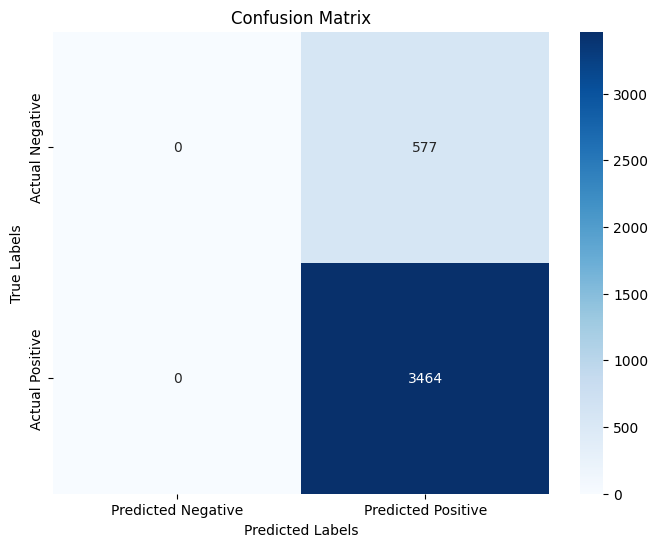

In [49]:
# Convert Credit Rating to Binary (Only if it has not already been converted to allow multiple tests)
if data_p2['Credit Rating'].dtype == 'object':  # Only apply if 'Credit Rating' is not already binary
    data_p2['Credit Rating'] = data_p2['Credit Rating'].apply(lambda x: 1 if x == 'Positive' else 0)

# Define feature columns and target column
X = data_p2[['Years of Education after High School', 'Requested Credit Amount',
             'Number of Dependents', 'Monthly Income', 'Monthly Expense',
             'Marital Status']]
y = data_p2['Credit Rating']

# Preprocessing for categorical features
categorical_features = ['Requested Credit Amount', 'Marital Status', 'Number of Dependents', 
                        'Monthly Income', 'Monthly Expense']
numerical_features = ['Years of Education after High School']

# Define preprocessing pipeline for categorical variables
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), categorical_features)
    ], remainder='passthrough'  # Keeps numerical features as they are
)

# Split dataset into 50% training and 50% testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

# Build the logistic regression pipeline
logreg_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear', max_iter=1000))
])

# Fit the model on the training data
logreg_pipeline.fit(X_train, y_train)

# Predict on the test set
y_pred = logreg_pipeline.predict(X_test)

# Calculate evaluation metrics
conf_matrix = confusion_matrix(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Display results
print("Confusion Matrix:\n", conf_matrix)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Part 2: Question 2

Positive Predictions: 606
Expected 15% Count: 606
New Threshold for Top 15%: 0.8875251208855517
Confusion Matrix (Adjusted):
 [[ 495   82]
 [2940  524]]
Precision (Adjusted): 0.8646864686468647
Recall (Adjusted): 0.151270207852194
F1 Score (Adjusted): 0.2574938574938575


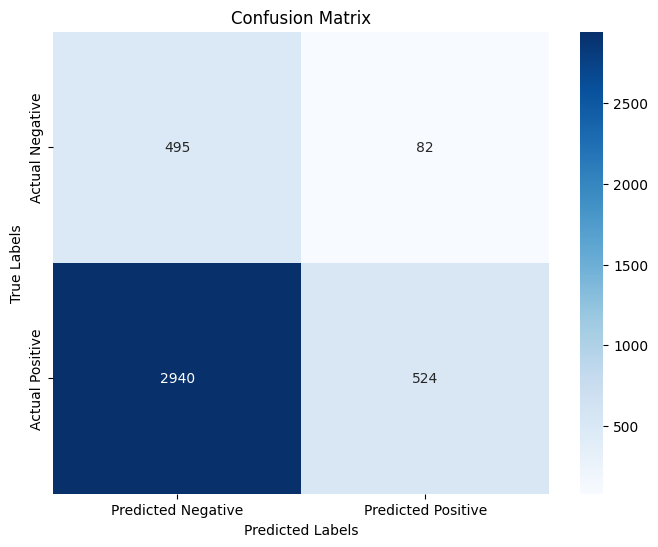

In [ ]:
# Use predicted probabilities and adjust the models scores according to the new threshold of top 15% of applicants

# Get predicted probabilities for the positive class
y_prob = logreg_pipeline.predict_proba(X_test)[:, 1]  # Probability for the positive class (1)

# Determine the threshold for the top 15% of predictions
# Sort the probabilities and pick the threshold that separates the top 15%
threshold = np.sort(y_prob)[-int(0.15 * len(y_prob))]

# Apply the new threshold to classify the test set
y_pred_adjusted = (y_prob >= threshold).astype(int)

# Calculate evaluation metrics with the new threshold
positive_count = y_pred_adjusted.sum()
expected_count = int(0.15 * len(y_pred_adjusted))
conf_matrix_adj = confusion_matrix(y_test, y_pred_adjusted)
precision_adj = precision_score(y_test, y_pred_adjusted)
recall_adj = recall_score(y_test, y_pred_adjusted)
f1_adj = f1_score(y_test, y_pred_adjusted)

# Display results
print("Positive Predictions:", positive_count)
print("Expected 15% Count:", expected_count)
print("New Threshold for Top 15%:", threshold)
print("Confusion Matrix (Adjusted):\n", conf_matrix_adj)
print("Precision (Adjusted):", precision_adj)
print("Recall (Adjusted):", recall_adj)
print("F1 Score (Adjusted):", f1_adj)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_adj, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
